In [1]:
# Import libraries

import numpy as np
from scipy.stats import multivariate_normal
from denmarf import DensityEstimate

# Plotting
import matplotlib
from matplotlib import pyplot as plt
import getdist
from getdist import MCSamples, plots
%matplotlib inline
%config InlineBackend.figure_format="retina"

In [2]:
%matplotlib inline

import h5py

import pandas as pd
from scipy.interpolate import interp1d
from astropy import cosmology, units

import bilby as bb
from bilby.core.prior import LogUniform, PriorDict, Uniform
from bilby.hyper.model import Model
import gwpopulation as gwpop

In [3]:
import pesummary
from pesummary.io import read

/home/manchun.yeung/.conda/envs/pop/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [61]:
from scipy.stats import norm
def naive(theta):
    min_val = theta.min()
    max_val = theta.max()
    
    # Normalize the data between 0 and 1, skipping elements that are exactly min or max
    U = np.zeros_like(theta)
    
    # Apply normalization only where theta is not min or max
    mask = (theta != min_val) & (theta != max_val)
    
    # Normalize values that are not min or max
    U[mask] = (theta[mask] - min_val) / (max_val - min_val)
    
    # Convert normalized values to Probit (inverse CDF of the standard normal distribution)
    # Skip the min and max values to avoid NaN/Inf issues
    theta_transformed = np.zeros_like(theta)
    theta_transformed[mask] = norm.ppf(U[mask])
    
    return theta_transformed

In [64]:
m1 = posterior_samples['mass_1'][:4096]
q = posterior_samples['mass_ratio'][:4096]

In [87]:
def cdf(samples):
    sorted_samples = np.sort(samples)
    # The CDF value for each sample is its rank (number of samples <= that value) divided by the total number of samples
    cdf_values = np.arange(1, len(sorted_samples) + 1) / len(sorted_samples)

    min_val = samples.min()
    max_val = samples.max()
    
    U = np.zeros_like(samples)
    
    # Apply normalization only where theta is not min or max
    mask = (samples != min_val) & (samples != max_val)

    def find_cdf(sample_value):
        # Ensure sample_value is a numpy array for consistent processing
        sample_value = np.asarray(sample_value)
        
        # Initialize an array to hold the CDF results
        cdf_result = np.zeros_like(sample_value, dtype=float)
        
        for i, value in enumerate(sample_value):
            # Find the index where the sample value would fit in the sorted array
            index = np.searchsorted(sorted_samples, value)
            if index == 0:
                cdf_result[i] = 0.0  # If the sample value is less than the smallest sample
            elif index >= len(cdf_values):
                cdf_result[i] = 1.0  # If the sample value is greater than the largest sample
            else:
                cdf_result[i] = cdf_values[index - 1]  # Return the corresponding CDF value
                
        return cdf_result

    U[mask] = find_cdf(samples[mask])
    transformed_samples = np.zeros_like(samples)
    transformed_samples = norm.ppf(U[mask])
    return transformed_samples

In [113]:
from jaxinterp2d import interp2d, CartesianGrid
from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm
import astropy.units as u

from jax import random, jit, vmap, grad


H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0

zMax = 5
zgrid = jnp.expm1(jnp.linspace(jnp.log(1), jnp.log(zMax+1), 500))
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,50)

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

rs = []
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)
    
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 50/50 [00:00<00:00, 81.15it/s] 


In [114]:
import h5py
jnp=np
# Read in attributes from injection summary file
injection_file = "ig_nb/endo3_bbhpop-LIGO-T2100113-v12.hdf5"
with h5py.File(injection_file, 'r') as f:
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']

    m1detsels = f['injections/mass1'][:]
    m2detsels = f['injections/mass2'][:]
    dLsels = f['injections/distance'][:]
    rasels = f['injections/right_ascension'][:]
    decsels = f['injections/declination'][:]

    p_draw = f['injections/sampling_pdf'][:]

    pastro_cwb = f['injections/pastro_cwb'][:]
    pastro_gstlal = f['injections/pastro_gstlal'][:]
    pastro_mbta = f['injections/pastro_mbta'][:]
    pastro_pycbc_bbh = f['injections/pastro_pycbc_bbh'][:]
    pastro_pycbc_broad = f['injections/pastro_pycbc_hyperbank'][:]

    ifar_cwb = f['injections/ifar_cwb'][:]
    ifar_gstlal = f['injections/ifar_gstlal'][:]
    ifar_mbta = f['injections/ifar_mbta'][:]
    ifar_pycbc_bbh = f['injections/ifar_pycbc_bbh'][:]
    ifar_pycbc_broad = f['injections/ifar_pycbc_hyperbank'][:]

selection = {
    'cwb': pastro_cwb > 0.5,
    'gstlal': pastro_gstlal > 0.5,
    'mbta': pastro_mbta > 0.5,
    'pycbc_bbh': pastro_pycbc_bbh > 0.5,
    'pycbc_broad': pastro_pycbc_broad > 0.5,
    'any': ((pastro_cwb > 0.5) | (pastro_gstlal > 0.5) | (pastro_mbta > 0.5) |
            (pastro_pycbc_bbh > 0.5) | (pastro_pycbc_broad > 0.5) ),
}

selection_ifar = {
    'cwb': ifar_cwb > 1,
    'gstlal': ifar_gstlal > 1,
    'mbta': ifar_mbta > 1,
    'pycbc_bbh': ifar_pycbc_bbh > 1,
    'pycbc_broad': ifar_pycbc_broad > 1,
    'any': ((ifar_cwb > 1) | (ifar_gstlal > 1) | (ifar_mbta > 1) |
            (ifar_pycbc_bbh > 1) | (ifar_pycbc_broad > 1) ),
    'cbc': ((ifar_gstlal > 1) | (ifar_pycbc_bbh > 1) | (ifar_pycbc_broad > 1) ),
}

sels = selection_ifar['cbc']
m1detsels = jnp.array(m1detsels[sels])
m2detsels = jnp.array(m2detsels[sels])
dLsels = jnp.array(dLsels[sels])
rasels = jnp.array(rasels[sels])
decsels = jnp.array(decsels[sels])
p_draw = jnp.array(p_draw[sels])

print(Ndraw)
print(p_draw.shape)
print(z_of_dL(dLsels,115,Om0grid[-1]).max())

# sns.distplot(z_of_dL(dLsels,H0Planck,Om0grid[-1]))
# sns.distplot(z_of_dL(dL,H0Planck,Om0grid[-1]))

73957576
(76202,)
3.143985253624205


In [118]:
with h5py.File(injection_file, 'r') as f:
    print(f['injections'].keys())

<KeysViewHDF5 ['declination', 'declination_sampling_pdf', 'detection_statistic_cwb', 'detection_statistic_mbta', 'detection_statistic_pycbc_bbh', 'detection_statistic_pycbc_hyperbank', 'distance', 'far_cwb', 'far_gstlal', 'far_mbta', 'far_pycbc_bbh', 'far_pycbc_hyperbank', 'full_sampling_pdf', 'gps_time', 'gps_time_int', 'ifar_cwb', 'ifar_gstlal', 'ifar_mbta', 'ifar_pycbc_bbh', 'ifar_pycbc_hyperbank', 'inclination', 'inclination_sampling_pdf', 'mass1', 'mass1_source', 'mass1_source_mass2_source_sampling_pdf', 'mass1_source_sampling_pdf', 'mass2', 'mass2_source', 'mixture_weight', 'optimal_snr_h', 'optimal_snr_l', 'optimal_snr_net', 'pastro_cwb', 'pastro_gstlal', 'pastro_mbta', 'pastro_pycbc_bbh', 'pastro_pycbc_hyperbank', 'polarization', 'polarization_sampling_pdf', 'redshift', 'redshift_sampling_pdf', 'right_ascension', 'right_ascension_sampling_pdf', 'sampling_pdf', 'spin1x', 'spin1x_spin1y_spin1z_sampling_pdf', 'spin1y', 'spin1z', 'spin2x', 'spin2x_spin2y_spin2z_sampling_pdf', 'spin

In [115]:
m1sels = m1detsels / (1+z_of_dL(dLsels,H0=H0Planck,Om0=Om0Planck))
m2sels = m2detsels / (1+z_of_dL(dLsels,H0=H0Planck,Om0=Om0Planck))

In [116]:
qsels = m2detsels/m1detsels

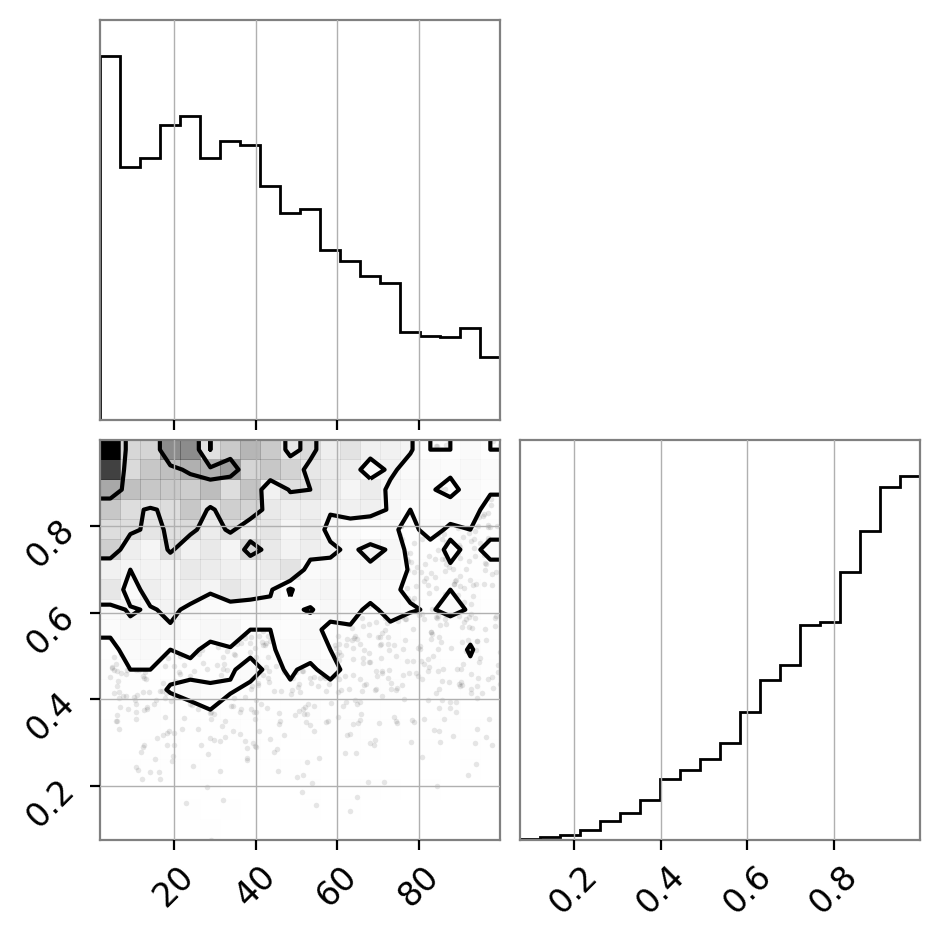

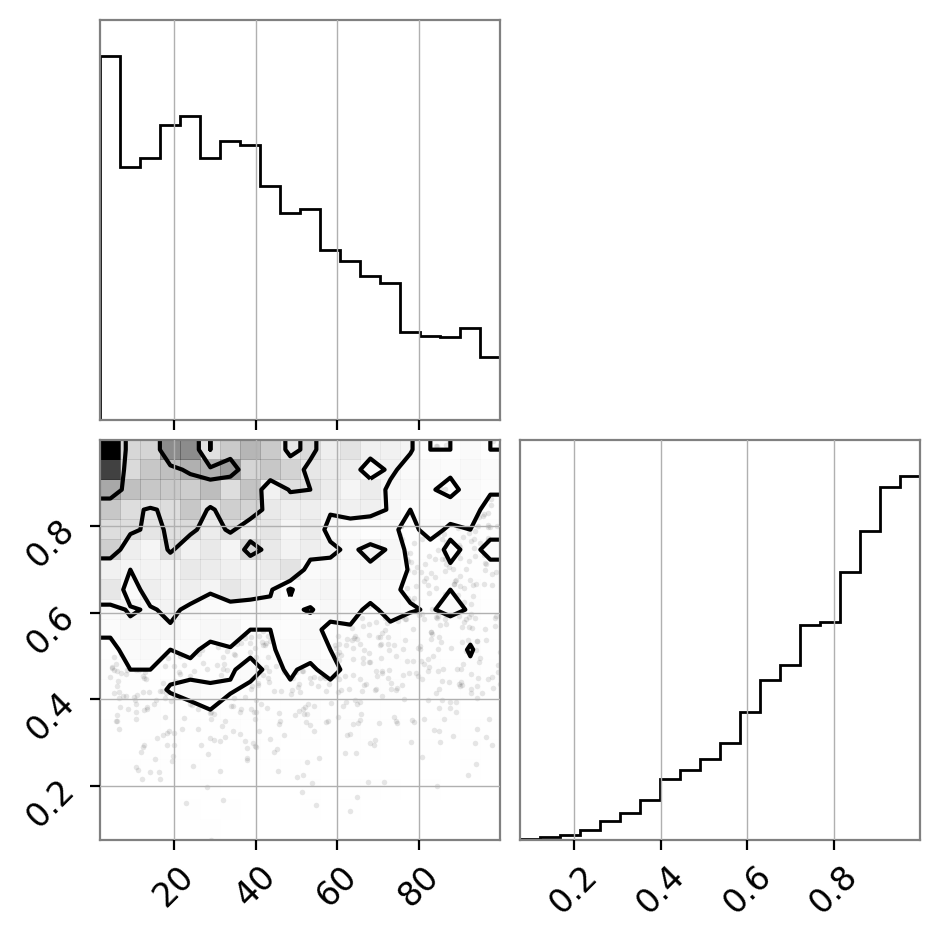

In [111]:
corner(np.column_stack([m1sels[:4096], qsels[:4096]]))

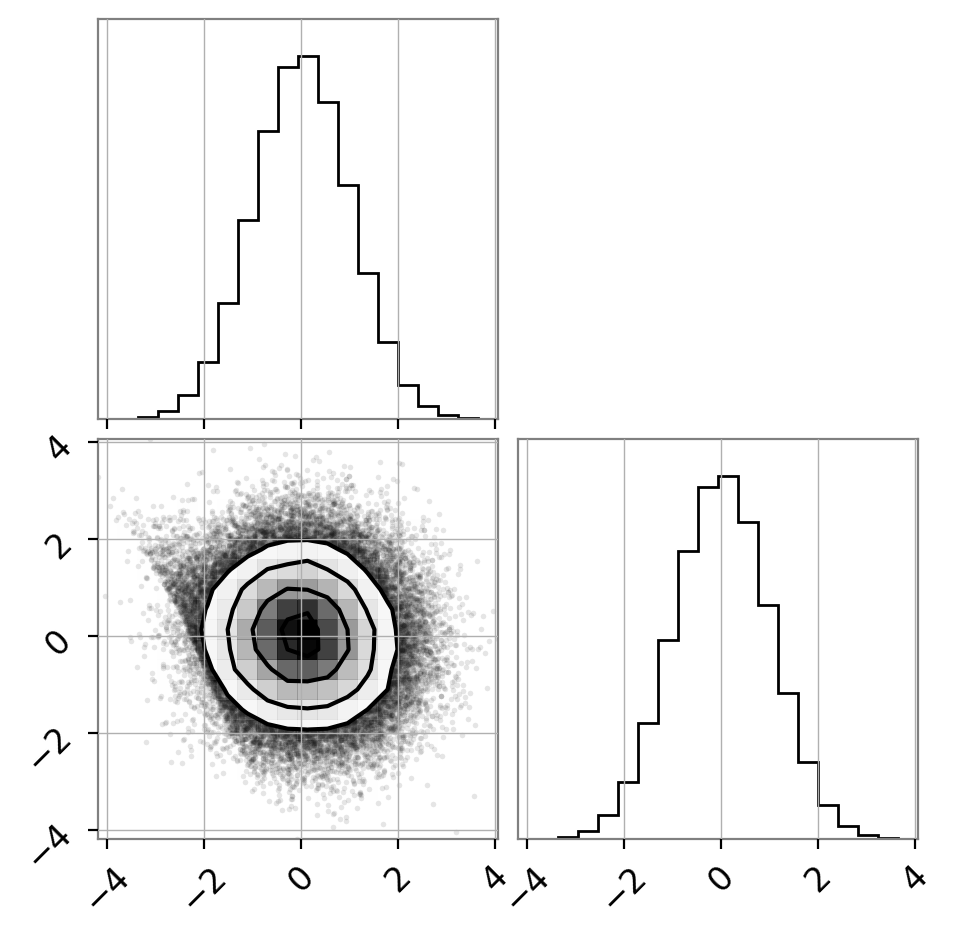

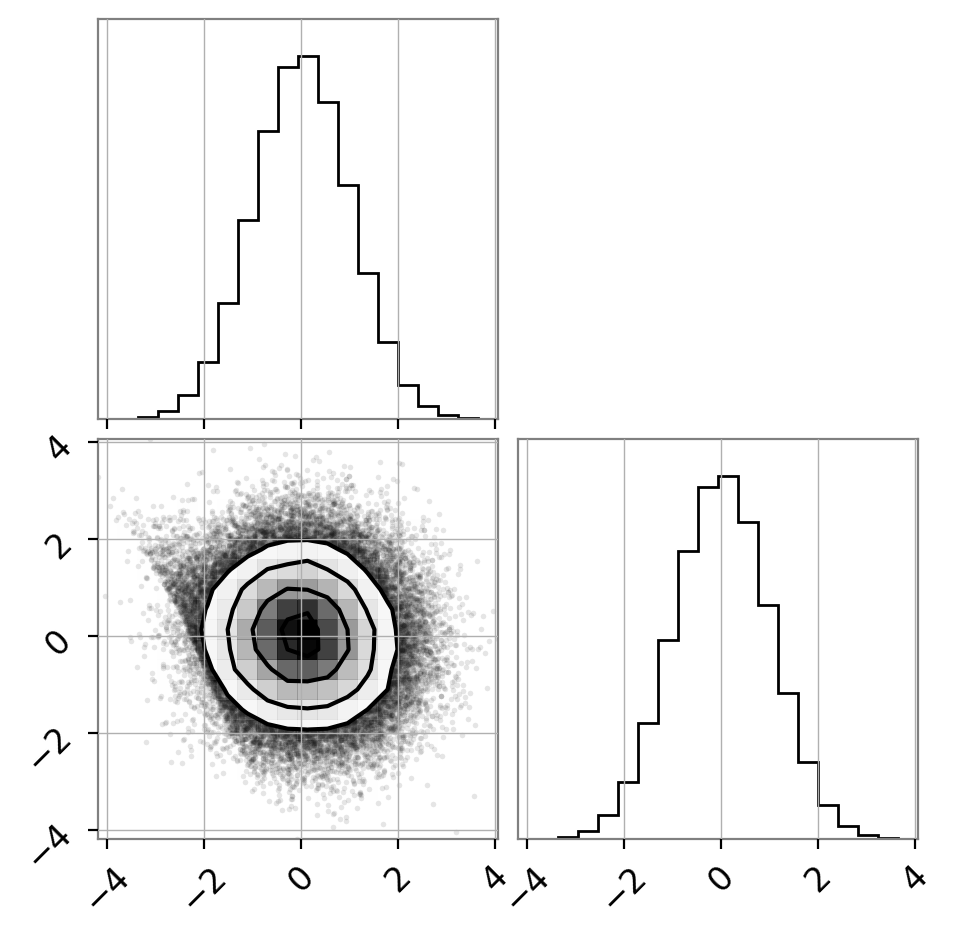

In [112]:
param2 = np.column_stack([cdf(m1sels), cdf(qsels)])
corner(param2)
# plt.savefig('plots/cdf.png')

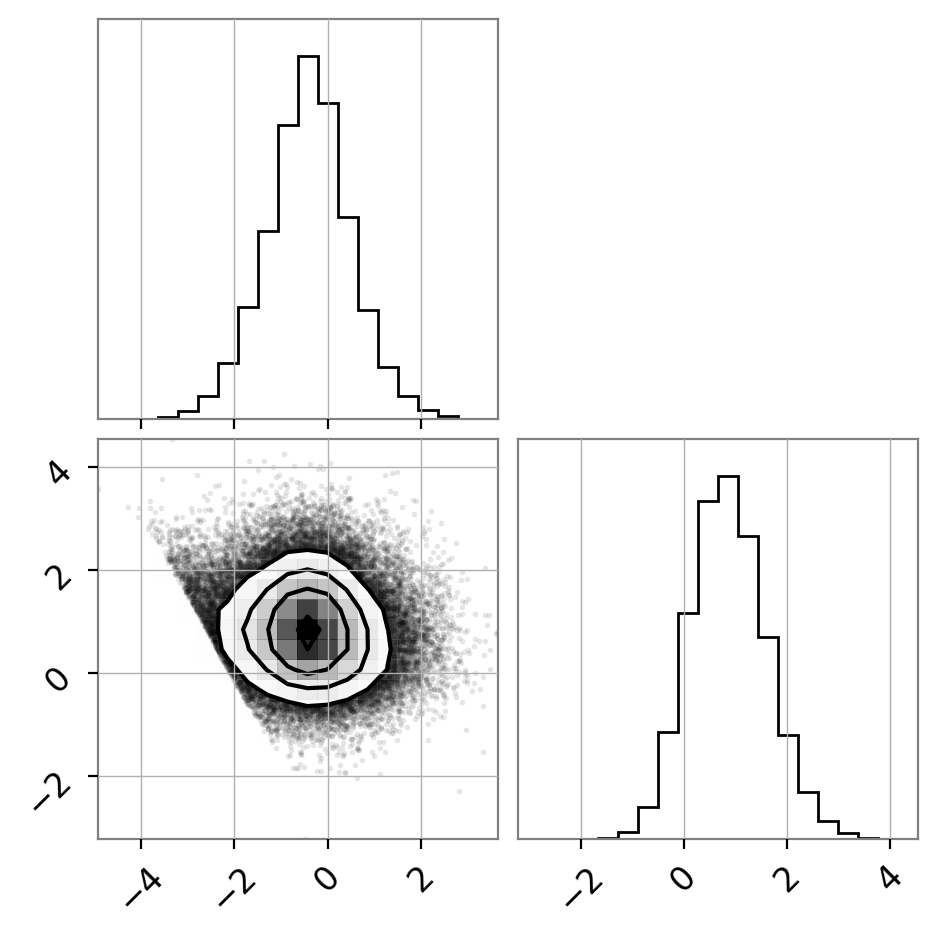

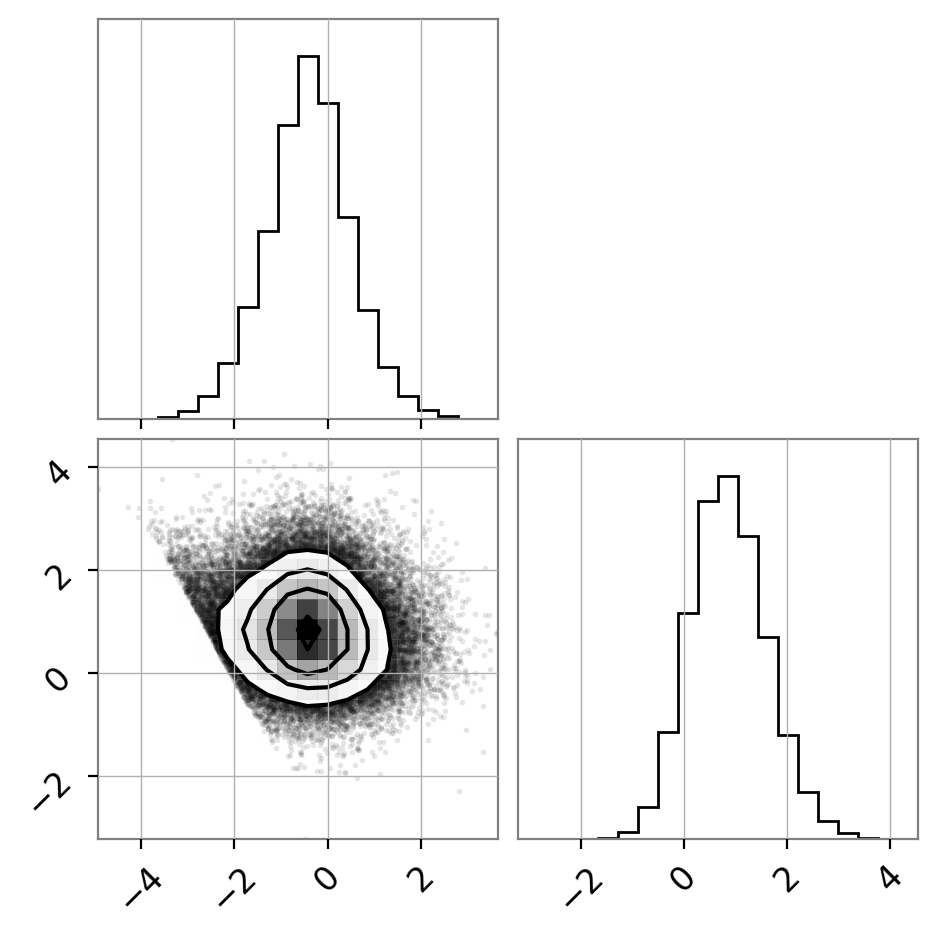

In [213]:
param3 = np.column_stack([naive(m1sels), naive(qsels)])
corner(param3)
# plt.savefig('plots/cdf.png')

In [182]:
from jax.scipy.stats import norm

m1_min = m1sels.min()
m1_max = m1sels.max()
m1s = np.linspace(m1_min, m1_max, 2000)

m2_min = m2sels.min()
m2_max = m2sels.max()
m2s = np.linspace(m2_min, m2_max, 2000)

q_min = qsels.min()
q_max = qsels.max()
qs = np.linspace(q_min, q_max, 2000)

mass = m1s
mass_ratio = qs

def Sfilter_low(m,m_min,dm_min):
    """
    Smoothed filter function

    See Eq. B5 in https://arxiv.org/pdf/2111.03634.pdf
    """
    def f(mm,deltaMM):
        return jnp.exp(deltaMM/mm + deltaMM/(mm-deltaMM))

    S_filter = 1./(f(m-m_min,dm_min) + 1.)
    S_filter = jnp.where(m<m_min+dm_min,S_filter,1.)
    S_filter = jnp.where(m>m_min,S_filter,0.)
    return S_filter

def Sfilter_high(m,m_max,dm_max):
    """
    Smoothed filter function

    See Eq. B5 in https://arxiv.org/pdf/2111.03634.pdf
    """
    def f(mm,deltaMM):
        return jnp.exp(deltaMM/mm + deltaMM/(mm-deltaMM))

    S_filter = 1./(f(m-m_max,-dm_max) + 1.)
    S_filter = jnp.where(m>m_max-dm_max,S_filter,1.)
    S_filter = jnp.where(m<m_max,S_filter,0.)
    return S_filter

def logpm1_powerlaw(m1,m_min,m_max,alpha,dm_min,dm_max):

    pm1 = Sfilter_low(mass,m_min,dm_min)*mass**(-alpha)*Sfilter_high(mass,m_max,dm_max)
    pm1 = pm1/jnp.trapz(pm1,mass)
    return jnp.log(jnp.interp(m1,mass,pm1))

def logpm1_peak(m1,mu,sigma):
    pm1 =  jnp.exp(-(mass - mu)**2 / (2 * sigma ** 2))
    pm1 = pm1/jnp.trapz(pm1,mass)
    return jnp.log(jnp.interp(m1,mass,pm1))

def logpm1_powerlaw_powerlaw(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,mu,sigma,f1):
    p1 = jnp.exp(logpm1_powerlaw(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1))
    p2 = jnp.exp(logpm1_peak(m1,mu,sigma))

    pm1 = (1-f1)*p1 + f1*p2
    return jnp.log(pm1)

def logpm1_powerlaw_GP(m1,z,mu,sigma):
  pass

def logfq(q,beta):
    pq = mass_ratio**beta
    pq = pq/jnp.trapz(pq,mass_ratio)

    log_pq = jnp.log(jnp.interp(q,mass_ratio,pq))

    return log_pq


In [236]:
from scipy.special import logsumexp


def approximate(m1sels, qsels, gamma1=3,m_min_1=0,m_max_1=110,alpha_1=3.3,dm_min_1=1,dm_max_1=10,beta=1,mu=50,sigma=3,f1=0.4):

    def p_det(m1, q):    
        p_det = m1**(2.35) * (q **2)
        return p_det

    m1sels = m1sels[(m1sels != m1sels.min()) & (m1sels != m1sels.max())]
    qsels = qsels[(qsels != qsels.min()) & (qsels != qsels.max())]
    
    m1_norm = scipy.integrate.trapezoid(np.exp(logpm1_powerlaw_powerlaw(m1s,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,mu,sigma,f1)+np.log(p_det(m1s, qs))), m1s)
    q_norm = scipy.integrate.trapezoid(np.exp(logfq(qs, beta)+np.log(p_det(m1s, qs))), qs)

    def nominators(m1sels, qsels):
        m1_array = np.array([np.linspace(m1_min, m1sels[i], 2000) for i in range(len(m1sels))])
        q_array = np.array([np.linspace(q_min, qsels[i], 2000) for i in range(len(qsels))])
        
        nom_m1 = np.array([
            scipy.integrate.trapezoid(
                np.exp(logpm1_powerlaw_powerlaw(m1_array, m_min_1, m_max_1, alpha_1, dm_min_1, dm_max_1, mu, sigma, f1)
                +np.log(p_det(m1_array, qs))), m1_array
            ) for i, m1_array in enumerate(m1_array)
        ])
        
        # Nominator for q
        nom_q = np.array([
            scipy.integrate.trapezoid(
                np.exp(logfq(q_array, beta)
                +np.log(p_det(m1s, q_array))), q_array
            ) for i, q_array in enumerate(q_array)
        ])
        return nom_m1, nom_q

    nom_m1, nom_q =  nominators(m1sels, qsels)
    trans_m1 = nom_m1 / m1_norm
    trans_q = nom_q / q_norm

    return trans_m1, trans_q

In [268]:
from scipy.stats import gaussian_kde

def empirical(theta):

    
    U = np.zeros_like(theta)

    def kde(theta):
        kernel_theta = gaussian_kde(theta)
        samples_theta = kernel_theta.resample(size = 76200)
        
        samples_theta_min, samples_theta_max = samples_theta.min(), samples_theta.max()
        kernel_theta_min = gaussian_kde(2*samples_theta_min - theta)
        kernel_theta_max = gaussian_kde(2*samples_theta_max - theta)
        min_theta = kernel_theta_min.resample(size = 76200)
        max_theta = kernel_theta_min.resample(size = 76200)

        return samples_theta[0] + min_theta[0] + max_theta[0]

    def integral(samples, sam_min, sam_max):
        sam_array = np.linspace(sam_min, sam_max, 2000)
        return np.trapz(samples)

    samples = kde(theta)
    min_val = samples.min()
    max_val = samples.max()
    mask = (samples != min_val) & (samples != max_val)

    
    U = integral(samples, min_val, max_val)
    print(U)
    transformed_samples = norm.ppf(U)
    return transformed_samples
    

In [269]:
np.isnan(empirical(m1sels))

-4787976.874908969


True

In [267]:
empirical(m1sels)

Array(nan, dtype=float32)

ValueError: Axis limits cannot be NaN or Inf

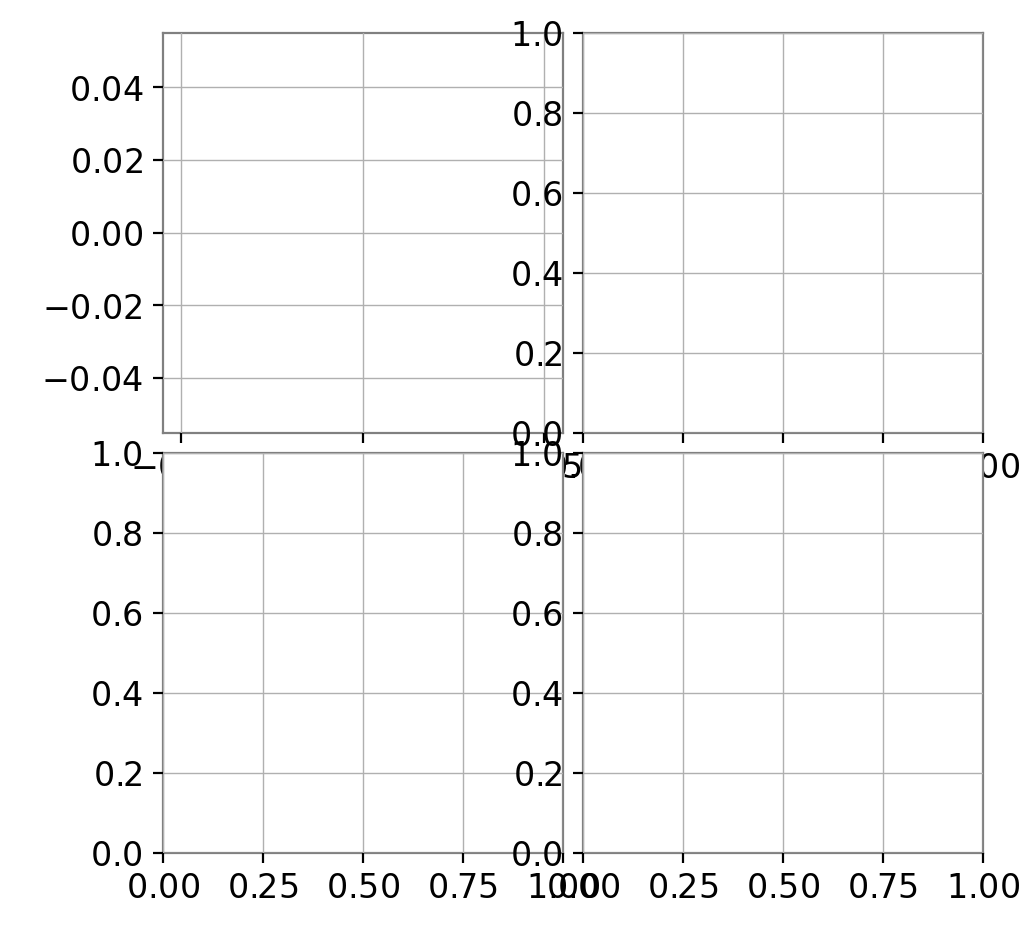

In [255]:
param3 = np.column_stack([empirical(m1sels), empirical(qsels)])
corner(param3)
# plt.savefig('plots/cdf.png')

In [219]:
gamma1 = 3
m_min_1 = 0
m_max_1 = 110
alpha_1 = 3.3
dm_min_1 = 1
dm_max_1 = 10
beta = 1
mu = 50
sigma = 3
f1 = 0.4

In [220]:
m1_norm = scipy.integrate.trapezoid(np.exp(logpm1_powerlaw_powerlaw(m1s,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,mu,sigma,f1)+np.log(p_det(m1s, qs))), m1s)


In [233]:
m1s, m1t

(array([  2.0007394 ,   2.0497931 ,   2.0988468 , ...,
         99.96097854, 100.01003224, 100.05908594]),
 array([ 2.0007394 ,  2.04526129,  2.08978319, ..., 90.91095622,
        90.95547811, 91.        ]))

In [231]:
m1t = np.linspace(m1_min, 91, 2000) 
m1_norm = scipy.integrate.trapezoid(np.exp(logpm1_powerlaw_powerlaw(m1t,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,mu,sigma,f1)+np.log(p_det(m1t, qsels[0]))), m1t)

In [243]:
m1_norm = scipy.integrate.trapezoid(np.exp(logpm1_powerlaw_powerlaw(m1s,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,mu,sigma,f1)+np.log(p_det(m1s, qs))), m1s)

In [244]:
m1_norm

1126.7903065080088

In [217]:
m1_norm

1149.910594981421

In [202]:
np.log(p_det(m1sels[0], qsels[0])), (2.35 * np.log(m1sels[0]) + 2 * np.log(qsels[0]))

(9.764298051677619, 9.764298001939741)

In [209]:
np.isnan(norm.ppf(tm1))

array([ True, False,  True, ..., False, False, False])

In [240]:
tm1[0]

1.1801496905362432

In [239]:
tm1, tq = approximate(m1sels, qsels)

In [ ]:
param3 = np.column_stack([norm.ppf(tm1), norm.ppf(tq)])
corner(param3)
# plt.savefig('plots/cdf.png')

In [151]:
q_array = np.array([np.linspace(qsels.min(), qsels[i], 2000) for i in range(len(qsels))])
m1_array = np.array([np.linspace(m1sels.min(), m1sels[i], 2000) for i in range(len(m1sels))])

In [179]:
def p_det(m1, q):    
    p_det = m1**(2.35) * (q **2)
    return p_det
import scipy
scipy.integrate.trapezoid(np.exp(logfq(q_array, beta=1)+np.log(p_det(m1_array, q_array))), q_array)

array([2278.53191278,    6.36822665, 2824.92638829, ...,
         38.7182994 ,  589.81202762,  383.25015424])

In [178]:
np.exp(logfq(q_array, beta=1)+np.log(p_det(m1_array, q_array)))

array([[4.39089985e-03, 4.67799472e-03, 4.97808333e-03, ...,
        2.29075424e+04, 2.29644308e+04, 2.30214339e+04],
       [4.39089985e-03, 4.46563718e-03, 4.54128023e-03, ...,
        3.90056375e+01, 3.90837170e+01, 3.91619217e+01],
       [4.39089985e-03, 4.59695008e-03, 4.81058580e-03, ...,
        1.84359467e+04, 1.84823874e+04, 1.85289232e+04],
       ...,
       [4.39089985e-03, 4.48203649e-03, 4.57461967e-03, ...,
        2.51889571e+02, 2.52466517e+02, 2.53044535e+02],
       [4.39089985e-03, 4.54542960e-03, 4.70426183e-03, ...,
        4.77712598e+03, 4.78894839e+03, 4.80079458e+03],
       [4.39089985e-03, 4.52997882e-03, 4.67257844e-03, ...,
        3.13515707e+03, 3.14287430e+03, 3.15060697e+03]])

In [167]:
logfq(qsels, beta=1)

array([0.27988292, 0.54415367, 0.68358838, ..., 0.60087564,
       0.46997375, 0.45609744])

In [168]:
log_p = np.log(p_det(m1_array, q_array))

In [173]:
p_det(np.array([2, 3]), np.array([4, 5]))

array([ 81.57188015, 330.50265854])

In [144]:
q_array

array([[0.07535008, 0.07564141, 0.07593275, ..., 0.65714618,
        0.65743752, 0.65772885],
       [0.07535008, 0.07574094, 0.0761318 , ..., 0.85589748,
        0.85628834, 0.8566792 ],
       [0.07535008, 0.07580506, 0.07626004, ..., 0.98394879,
        0.98440377, 0.98485875],
       ...,
       [0.07535008, 0.07576595, 0.07618182, ..., 0.90584455,
        0.90626042, 0.90667629],
       [0.07535008, 0.0757103 , 0.07607052, ..., 0.79471016,
        0.79507038, 0.7954306 ],
       [0.07535008, 0.07570481, 0.07605955, ..., 0.78375971,
        0.78411445, 0.78446919]])

In [141]:
qsels.min()

0.075350076

In [136]:
q_array[2]

array([0.07593275, 0.0761318 , 0.07626004, ..., 0.07618182,
       0.07607052, 0.07605955], dtype=float32)

In [73]:
np.any(np.isinf(cdf(posterior_samples['mass_1'][:4096])))

True

In [74]:
np.where(np.isinf(cdf(posterior_samples['mass_1'][:4096])))[0]

array([1551])

In [78]:
cdf(m1)[1551], norm.ppf(0)

(-inf, -inf)

In [58]:
naive(posterior_samples['mass_1'][10])

nan 0.0 0.0


/local/manchun.yeung@ligo.org/ipykernel_2879433/1977220499.py:5: RuntimeWarning: invalid value encountered in scalar divide
  U = (theta-min)/(max-min)


nan

In [60]:
posterior_samples['mass_1'][10]

90.02158473956841

In [59]:
posterior_samples['mass_1'][:4096].min(), posterior_samples['mass_1'][:4096].max() 

(Array(40.41923642), Array(90.02158474))